# Pytorch image generator GAN

I created this to see if cancer images could be generated by AI to create synthetic pathology data, but it is set up to take a variety of images.

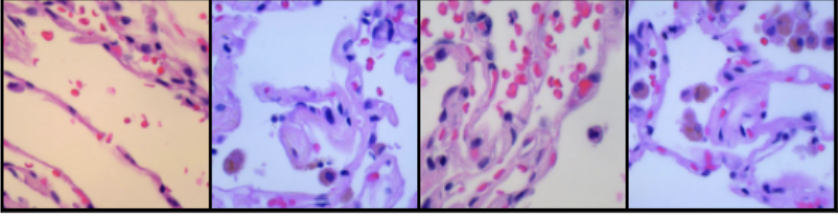

Here we mount Google Drive to the directory so we can put our image data there to call it. If you download this and want to use it on Jupyter Notebooks, disregard this.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Import dependancies and data. I used the Kaggle dataset [Lung and Colon Cancer Histopathic Images](https://www.kaggle.com/andrewmvd/lung-and-colon-cancer-histopathological-images)

But again, you could use something else.



In [ ]:
import os
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, ConcatDataset

from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torchvision.utils import save_image

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.notebook import tqdm

#swap the path here for the images you want to use
image_dir = "/content/drive/MyDrive/lungcancer"
out_dir = 'output'
#make a place to send results
os.makedirs(out_dir, exist_ok=True)

#standardizes the image sizes and sets the seed
image_size= 64
batch_size= 64
norm_stats=(0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
set_seed = 111

#preforms device based functions

def send_device(dataloader, device):
    if isinstance(dataloader, (list,tuple)):
        return [send_device(num, device) for num in dataloader]
    return dataloader.to(device, non_blocking=True)
class DeviceObj():
    def __bytes__(self):
      return bytes(self.dataloader)
    def __init__(self, dataloader, device):
        self.dataloader = data_loader
        self.device = device
    def gpuAvailable():
      if torch.cuda.is_available():
        return True
    def __iter__(self):
        for b in self.dataloader: 
            yield send_device(b, self.device)
    def set_device():
      if torch.cuda.is_available():
        return torch.device('cuda')
      else :
        return torch.device('cpu')
    def __len__(self):
        return len(self.dataloader)

#my computer does not have a compatable graphics card, 
#but if yours does this will make things better
device= DeviceObj.set_device()

#we need to denormalize whenever we want to see the image
def denormalize(image):
    return image * norm_stats[1][0] + norm_stats[0][0]

Load the dataset and normalize it so our GAN can use it

In [ ]:
norm_dataset = ImageFolder(
    image_dir, transform=transforms.Compose([
                                              transforms.Resize(image_size),
                                              transforms.ToTensor(),
                                              transforms.Normalize(
                                                  *norm_stats)]))
data_loader = DataLoader(
    norm_dataset,batch_size,shuffle=True,num_workers=4,pin_memory=True)

Check that the images loaded

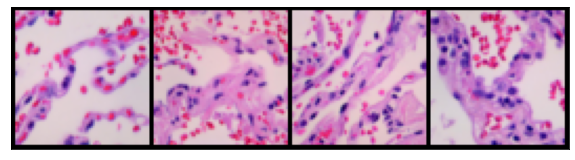

In [ ]:
images_to_display = 4
    
def check_images(data, images_to_display):
    for images, _ in data:
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.set_xticks([]) 
        ax.set_yticks([])
        ax.imshow(make_grid(denormalize(images.detach()[:images_to_display]), nrow=4).permute(1, 2, 0))
        break
  
#This should show a row of four images if it worked
check_images(data_loader, images_to_display)

The Descriminator and Generator are ordered and sent to the device


In [ ]:
#Descrminator and Generator
discriminator = nn.Sequential(OrderedDict([
    #3 x 64 x 64
    ('conv1', nn.Conv2d(
        3, 64, kernel_size=4, stride=2, padding=1, bias=False)),
    ('batchnorm1', nn.BatchNorm2d(64)),
    ('leru1', nn.LeakyReLU(0.2, inplace=True)),
    #64 x 32 x 32
    ('conv2', nn.Conv2d(
        64, 128, kernel_size=4, stride=2, padding=1, bias=False)),
    ('batchnorm2', nn.BatchNorm2d(128)),
    ('leru2', nn.LeakyReLU(0.2, inplace=True)),
    #128 x 16 x 16
    ('conv3', nn.Conv2d(
        128, 128, kernel_size=4, stride=2, padding=1, bias=False)),
    ('batchnorm3', nn.BatchNorm2d(128)),
    ('leru3', nn.LeakyReLU(0.2, inplace=True)),
    #128 x 8 x 8
    ('conv4', nn.Conv2d
     (128, 128, kernel_size=4, stride=2, padding=1, bias=False)),
    ('batchnorm4', nn.BatchNorm2d(128)),
    ('leru4', nn.LeakyReLU(0.2, inplace=True)),
    #128 x 4 x 4
    ('conv5', nn.Conv2d(
        128, 1, kernel_size=4, stride=1, padding=0, bias=False)),
    ('flat', nn.Flatten()),
    ('sig',nn.Sigmoid())
]))
generator = nn.Sequential(OrderedDict([
    # seed x 1 x 1
    ('convt1',nn.ConvTranspose2d(
        set_seed, 128, kernel_size=4, padding=0, stride=1, bias=False)),
    ('batchnorm1',nn.BatchNorm2d(128)),
    ('relu1',nn.ReLU(True)),
    # 256 x 4 x 4
    ('convt2',nn.ConvTranspose2d(
        128, 128, kernel_size=4, padding=1, stride=2, bias=False)),
    ('batchnorm2',nn.BatchNorm2d(128)),
    ('relu2',nn.ReLU(True)),
    #128 x 8 x 8
    ('convt3',nn.ConvTranspose2d(
        128, 128, kernel_size=4, padding=1, stride=2, bias=False)),
    ('batchnorm3',nn.BatchNorm2d(128)),
    ('relu3',nn.ReLU(True)),
    # 64 x 16 x 16
    ('convt4',nn.ConvTranspose2d(
        128, 64, kernel_size=4, padding=1, stride=2, bias=False)),
    ('batchnorm4',nn.BatchNorm2d(64)),
    ('relu4',nn.ReLU(True)),
    #32 x 32 x 32
    ('convt5',nn.ConvTranspose2d(
        64, 3, kernel_size=4, padding=1, stride=2, bias=False)),
    ('tahn',nn.Tanh())
    #3 x 64 x 64
]))

# Send them to device
discriminator = send_device(discriminator, device)
generator = send_device(generator, device)

Here we train the model.

In [ ]:
#Math functions for the training functions

#this adds noise
def target_noise(size):
    tnoise=torch.rand(size, 1, device=device) * (0.1)
    return tnoise
#this adds noise with a normal distribution
def nnoise():
    nnoise= torch.randn(batch_size, set_seed, 1, 1, device=device)
    return nnoise

def lossentropy(a,b):
    loss= F.binary_cross_entropy(a,b)
    return loss

def disc_loss_calc(rloss, gloss):
    sum = rloss + gloss
    sum.backward()
    return sum

def gen_loss_calc(dpred, target):
    loss = lossentropy(dpred, target)
    loss.backward()
    return loss

def mean_val(pred):
  return torch.mean(pred).item()

def optimize(param):
    beta = 0.5, 0.9
    rate= .0025 
    opt = torch.optim.Adam(param, lr = rate, betas = beta)
    return opt

device_data = DeviceObj(data_loader, device)

#training 
def train_disc(data, d_optimizer):
    d_optimizer.zero_grad()
    r_predictions = discriminator(data)
    r_targets= target_noise(data.size(0))
    r_loss = lossentropy(r_predictions, r_targets)
    r_score = mean_val(r_predictions)
    latent_g = generator(nnoise())
    g_predictions = discriminator(latent_g)
    g_targets = target_noise(latent_g.size(0))+ .9
    g_loss = lossentropy(g_predictions, g_targets)
    g_score = mean_val(g_predictions)
    t_loss=disc_loss_calc(r_loss, g_loss)
    d_optimizer.step()
    return t_loss.item(), r_score, g_score

def train_gen(g_optimizer):
    g_optimizer.zero_grad()
    latent_g = generator(nnoise())
    d_predictions = discriminator(latent_g)
    targets = torch.zeros(latent_g.size(0), 1, device=device)
    loss = gen_loss_calc(d_predictions, targets)
    g_optimizer.step()
    return loss.item()

def train(epochs):
    idx=1
    d_optimizer = optimize(discriminator.parameters())
    g_optimizer = optimize(generator.parameters())
    d_losses = d_scores = g_losses = g_scores = []
    for epoch in range(epochs):
        for real_img, _ in tqdm(device_data):
            d_loss, r_score, g_score = train_disc(real_img, d_optimizer)
            g_loss = train_gen(g_optimizer)
        g_losses.append(g_loss); g_scores.append(g_score)
        d_losses.append(d_loss); d_scores.append(r_score)
        print("Epoch # {}, G score: {:.5f}, D Score: {:.5f}".format(
            epoch+idx, r_score, g_score))
        export(epoch + idx)
    return d_losses, d_scores, g_losses, g_scores

def export(index):
    img_name = "epoch_{0:0=3d}.jpg".format(index)
    save_image(
        denormalize(
            generator(nnoise())), os.path.join(out_dir, img_name), nrow=8)

This will start the training. 

On my machine each epoch takes about 5 minutes so it may be a while. You can check the time next to the finished epoch loading bars. It tends to be consistant throughout.

In [ ]:
epochs = 50
run_gan = train(epochs)

At the end of each epoch your result should be in a directory called output.

Below is a gif of 50 epochs for me

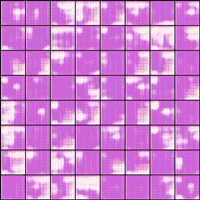

Citations


Borkowski, A. A., Bui, M. M., Thomas, L. B., Wilson, C. P., DeLand, L. A., & Mastorides, S. M. (2019). Lung and Colon Cancer Histopathological Image Dataset (LC25000). arXiv preprint arXiv:1912.12142.

Ghorbani, A., Natarajan, V., Coz, D., & Liu, Y. (2020, April). DermGAN: synthetic generation of clinical skin images with pathology. In Machine Learning for Health Workshop (pp. 155-170). PMLR.


